# <a id='title'></a> Exploring gridded data on Aerosol properties available on C3S

This first notebook provides a practical introduction to the 
[C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
dataset.

We give a short introduction to the ECV Aerosol Properties, which contains 4 total column variables: Aerosol Optical Depth (AOD), AOD of components (Fine Mode, Dust), and aerosol single scattering albedo (SSA) as a measure of aerosol absorption; and 2 vertically resolved variables:  (dust) aerosol layer height and stratospheric aerosol extinction coefficient (vertical profiles). The algorithms and best practices for these aerosol properties have been developed within the ESA Climate Change Initiative (CCI) and then were transferred for further extension and regular reprocessing + user support to the C3S. We start by downloading the data from the Climate Data Store (CDS) and then demonstrate three use cases for monthly mean single sensor datasets: plot a global mean map, calculate and plot a regional time series and calculate and plot a regional multi-annual mean ("climatology") and anomaly maps and time series.

The notebook has seven main sections with the following outline:


# Table of Contents

* [Introduction](#intro)
* [Download Data Using CDS API](#cdsapi)
* [Use case 1: Plot Map](#map_plot)
* [Use case 2: Regional time series](#timeseries)
* [Use case 3: "Climatology" (multi-annual mean) and Anomaly - maps and time series](#climatology)
* [Use case 4: Visualize Vertical Profile data](#vertical)
* [References](#references)

### How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

|Binder|Kaggle|Colab|NBViewer|
|:-:|:-:|:-:|:-:|
|[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/C3S_climate-data-store.ipynb)|[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store.ipynb)|[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store)|[![NBViewer](https://raw.githubusercontent.com/ecmwf-projects/copernicus-training/master/img/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store.ipynb)|
|(Binder may take some time to load, so please be patient!)|(will need to login/register, and switch on the internet via *settings*)|(will need to run the command `!pip install cartopy` before importing the libraries)|(this will not run the notebook, only render it)|

If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need. You will also need to install the CDS API (`pip install cdsapi`) for downloading data in batch mode from the CDS.

# <a id='intro'></a> Introduction


<br>
<div style="text-align: justify"> Aerosols are minor constituents of the atmosphere by mass, but critical components in terms of impact on climate. Aerosols influence the global radiation balance directly by scattering and absorbing radiation, and indirectly through influencing cloud reflectivity, cloud cover and cloud lifetime. Aerosols have a lifetime in the atmosphere of a few days up to a week so that they can be transported over thousands of kilometers. They are emitted from several different sources (e.g. natural and anthropogenic combustion processes, biogenic secondary organics, sea spray uplifting over oceans, mineral dust erosion from deserts, volcanic eruptions). Due to the inhomogenous distribution and episodic or seasonal / diurnal patterns of the various sources they exhibit large spatial and temporal variability. The different sources emmit a large range of different aerosol particles with sizes from few nanometers to many micrometers and different chemical composition. On global average aerosol have not changed over the last decades, but regionally there are significant trends and major episodes could be observed (e.g. Australian wildfires, Sahara outbreaks). </div>

### <a id='data_description'></a> Data description

<div style="text-align: justify"> The main variables provided by this dataset are meant to cover all relevant information on the global atmospheric aerosol distribution: aerosol optical depth (total abundance), fine mode aerosol optical depth (particles with diameter smaller than 1 micron), dust aerosol optical depth (mineral dust), single scattering albedo (ranging from 0 = fully absorbing to 1 = non-absorbing), (dust) aerosol layer height and stratospheric aerosol extinction coefficient (vertical profiles). These variables are derived from observations from several satellite sensors using a set of different processing techniques. This provides the possibility to derive a large set of complementary aerosol properties needed to describe the complex nature of atmospheric aerosols. Furthermore, different algorithms have their specific strengths and weaknesses, meaning that datasets originating from the same sensor but processed by different algorithms provide a way to evaluate uncertainties (e.g. areas of good or bad agreement between them). Altogether, the aerosol properties dataset is very extensive and offers a choice of complementary options – which is appropriate depends on the intended application. </div>

The data are provided in netCDF format.

Please find further information about the dataset as well as the data in the Climate Data Store catalogue entry Aerosol properties, sections "Overview", "Download data" and "Documentation": 
- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)

There in the "Documentation" part, one can find the Product User Guide and Specifications (PUGS) and the Algorithm Theoretical Baseline (ATBD) for further information on the different algorithms.

### Import libraries

We will be working with data in NetCDF format. To best handle this data we will use the netCDF4 python library. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it: <br>


In [1]:
#!pip install cdsapi

In [2]:

# Import libraries needed for the Jupyter notebook

%matplotlib inline

# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import xarray as xr
import pandas as pd

# Library to work with zip-archives, OS-functions and pattern expansion
import zipfile
import os
from pathlib import Path

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib as mplt
import matplotlib.dates as md
import cartopy.crs as ccrs
import datetime
import matplotlib.dates as mdates

# Libraries for style parameters
from pylab import rcParams
import seaborn

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

In [5]:
# The following style parameters will be used for all plots in this notebook.
# mplt.style.use('seaborn')
rcParams['figure.figsize'] = [15, 5]
rcParams['figure.dpi'] = 350
rcParams['font.family'] =  'serif'
rcParams['font.serif']  =  mplt.rcParamsDefault['font.serif']
rcParams['mathtext.default'] = 'regular'
rcParams['mathtext.rm'] = 'serif:light'
rcParams['mathtext.it'] = 'serif:italic'
rcParams['mathtext.bf'] = 'serif:bold'
plt.rc('font', size=17)          # controls default text sizes
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=17)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

projection=ccrs.PlateCarree()
mplt.rc('xtick', labelsize=9) 
mplt.rc('ytick', labelsize=9)

# <a id='cdsapi'></a> Download data using CDS API

### CDS API credentials

<div style="text-align: justify"> We will request data from the Climate Data Store (CDS): https://cds.climate.copernicus.eu/cdsapp#!/home. In case you don't have an account yet, please click on "Login/register" at the right top and select "Create new account". With the process finished you are able to login to the CDS and can search for your preferred data.</div>

We will request data from the CDS in batch mode with the help of the CDS API. 
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.


In [7]:
# Specify the CDS path for data access and your personal access key

URL = 'https://cds.climate.copernicus.eu/api'
KEY = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

Next, we specify a data directory in which we will download our data and all output files that we will generate:

In [8]:
# Specify local data directories for the downloads and the plot files

DATADIR='./'
PLOTDIR=DATADIR + 'plots/'
if not os.path.exists(PLOTDIR):
    os.mkdir(PLOTDIR)

Then we can search for data.

To search for data, visit the CDS website: https://cds.climate.copernicus.eu/cdsapp#!/home.
Here you can search for aerosol data using the search bar. The data we need for this use case is the [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview).
The Aerosol properties comprise several total column aerosol variables: (total) AOD, Fine-Mode AOD, Dust AOD, Single Scattering Albedo and further vertically resolved aerosol variables: stratospheric extinction profiles, aerosol layer height. Most catalogue entries comprise data from a number of sensors and algorithms.

Having selected the correct catalogue entry, we now need to specify the time aggregation, variable, sensor, algorithm, and temporal coverage we are interested in; the datasets are all global. 
These can all be selected in the **"Download data"** tab. In this tab a form appears  which guides the user to select existing combinations of the following parameters to download:

- Time aggregation: `Monthly`
- Variable: `Dust Aerosol Optical Depth`
- Sensor on satellite: `IASI on METOP-C`
- Algorithm: `ULB`
- Year: (use "Select all" button)
- Month: (use "Select all" button)
- Version: (choose the latest version / highest number for this sensor / algorithm) 
- Format: `Compressed zip file (.zip)`
- Orbit: `Descending` (for IASI only)

If you have not already done so, you will need to accept the **terms & conditions** of the data before you can download it.

At the end of the download form, select **`Show API request`**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below) ...

Depending on the length of the record chosen and the internet traffic the download may take one to several minutes.

To illustrate the variability we include 4 examples below (2 as comment lines only).

In [9]:
# Define the API for the CDS access

c = cdsapi.Client(url=URL, key=KEY)

# Define the dataset which shall be downloaded: time aggregation, sensor name, algorithm name, years, version number, orbit type (IASI only)
# uncomment one block of definitions (all lines with heading "#N") according to your choice of dataset 
# (or copy similar definitions from the CDS for all other datasets available)

# Retrieve the datasets from the CDS
c.retrieve(
    'satellite-aerosol-properties',
    {
        'format': 'zip',
        'month': ['%02d' % (mnth) for mnth in range(1, 13)],

        # First example: SLSTR Dual-view Radiometer data record (Fine Mode AOD)
        # SLSTR on Sentinel-3A: Swansea algorithm, Fine Mode AOD
        #1 'time_aggregation': 'monthly_average',
        #1 'variable': 'fine_mode_aerosol_optical_depth',
        #1 'sensor_on_satellite': 'slstr_on_sentinel_3a',
        #1 'algorithm': 'swansea',
        #1 'year': ['2017', '2018', '2019','2020', '2021', '2022','2023'],
        #1 'version': 'v1.12',
    
        # Second example: IASI Thermal Infrared Spectrometer data record (Dust AOD)
        # IASI on METOP-C: ULB algorithm, Dust AOD
        'time_aggregation': 'monthly_average',
        'variable': 'dust_aerosol_optical_depth',
        'sensor_on_satellite': 'iasi_on_metopc',
        'algorithm': 'ulb',
        'year': ['2019', '2020', '2021','2022',],
        'version': 'v9',
        'orbit': 'descending',

        # Third example: POLDER Polarimeter data record (Single Scattering Albedo)
        # POLDER on PARASOL: GRASP algorithm, single scattering albedo
        #3 'time_aggregation': 'monthly_average',
        #3 'variable': 'single_scattering_albedo',
        #3 'sensor_on_satellite': 'polder_on_parasol',
        #3 'algorithm': 'grasp',
        #3 'year': ['2005', '2006', '2007','2008', '2009', '2010','2011', '2012', '2013',],
        #3 'version': 'v2.10',

        # Fourth example: IASI Thermal Infrared Spectrometer data record (Dust Aerosol Layer Height)
        # IASI on METOP-C: LMD algorithm, dust layer height
        #4 'time_aggregation': 'monthly_average',
        #4 'variable': 'dust_aerosol_layer_height',
        #4 'sensor_on_satellite': 'iasi_on_metopc',
        #4 'algorithm': 'lmd',
        #4 'year': ['2019', '2020', '2021','2022',],
        #4 'version': 'v2.2',
        #4 'orbit': 'descending',
        
    },
    'download.zip')

2024-11-06 15:00:50,576 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-06 15:00:50,576 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informative page](https://confluence.ecmwf.int/x/uINmFw) for guidance.
2024-11-06 15:00:50,577 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-06 15:00:50,577 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-06 15:00:50,578 WARNING [2024-06-16T

'download.zip'

Please define your dataset characteristics (copy from above as used in the CDS Download page).

IMPORTANT NOTE: If you have once downloaded a specific dataset and want to re-use it, you can re-start from here using this dataset. Then you need to skip the code block "Unpack the data".

In [10]:
# Define the specifications of your dataset: algorithm name, sensor name, variable, years
# uncomment one block below (all lines with heading "#N") matching your downloaded dataset above, i.e. all lines with the same "#N" in front  
# (or copy from the code block above for any other dataset)

# select all months of each year
months = ['%02d' % (mnth) for mnth in range(1, 13)]

# First example: SLSTR Dual-view Radiometer data record (Fine Mode AOD)
# SLSTR on Sentinel-3A: Swansea algorithm, Fine Mode AOD
#1 algorithm = "swansea"
#1 sensor_on_satellite = "slstr_on_sentinel_3a"
#1 variable = 'fine_mode_aerosol_optical_depth'
#1 years = ['%04d'%(yea) for yea in range(2017, 2023)]

# Second example: IASI Thermal Infrared Spectrometer data record (Dust AOD)
# IASI on METOP-C: ULB algorithm, Dust AOD
algorithm = "ulb"
sensor_on_satellite = "iasi_on_metopc"
variable = 'dust_aerosol_optical_depth'
years = ['%04d'%(yea) for yea in range(2019, 2023)]

# Third example: POLDER Polarimeter data record (Single Scattering Albedo)
# POLDER on PARASOL: GRASP algorithm, single scattering albedo
#3 algorithm = "grasp"
#3 sensor_on_satellite = "polder_on_parasol"
#3 variable = 'single_scattering_albedo'
#3 years = ['%04d'%(yea) for yea in range(2005, 2013)]

# Fourth example: IASI Thermal Infrared Spectrometer data record (Dust Aerosol Layer Height)
# IASI on METOP-C: ULB algorithm, Dust ALH
#4 algorithm = "lmd"
#4 sensor_on_satellite = "iasi_on_metopc"
#4 variable = 'dust_aerosol_layer_height'
#4 years = ['%04d'%(yea) for yea in range(2019, 2023)]


Correction of variable names: There are a few variable naming inconsistencies which we automatically adjust by the following code block.

Those inconsistencies are remaining despite of strong format harmonization efforts from the fact that the algorithms / datasets come from different providers who have somewhat different coding practices.

In [11]:
# Run the following code lines to automatically replace all variable names which are inconsistent, so that you need not care any further

if variable == 'aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'AOD550'
    else:
        variable = 'AOD550_mean'
elif variable == 'fine_mode_aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'FM_AOD550'
    else:
        variable = 'FM_AOD550_mean'
elif variable == 'dust_aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'DAOD550'
    elif algorithm == 'lmd':
        variable = 'Daod550'
    elif algorithm == 'imars':
        variable = 'D_AOD550'
    else:
        variable = 'D_AOD550_mean'
elif variable == 'single_scattering_albedo':
    variable = 'SSA443'
elif variable == 'dust_aerosol_layer_height':
    if algorithm == 'lmd':
        variable = 'Mean_dust_layer_altitude'
    if algorithm == 'mapir':
        variable = 'D_ALT_mean'

### Unpack the data

The zip-files have now been requested and downloaded to the data directory that we have specified earlier.
For the purposes of our use cases, we will unzip the archive and store all netCDF files in a specific directory for this algorithm.
There you can also search and open individual files with any tool suitable for reading netCDF format, e.g. Panoply.
The files contain gridded data with 1 degree spatial resolution.

IMPORTANT NOTE: If you had already downloaded and unzipped the record you intend to visualize now, then you need to skip this block. (To check you need to confirm that the directory time series_<algorithm>1 exists and contains all the monthly data you intend to use).
    

In [12]:
# Unpack the downloaded data to a predefined sub directory for the selected dataset 
# (which can be used for future applications of the Jupyter notebook without repeating the download)

with zipfile.ZipFile(f'{DATADIR}download.zip', 'r') as zip_ref:
    zip_ref.extractall('timeseries_' + algorithm + '1')
dir = f'{DATADIR}' + 'timeseries_' + algorithm + '1/'
files = os.listdir(dir)

# <a id='map_plot'></a> Use case 1: Plot map


Firstly, we should get an overview of the parameter by plotting the time averaged monthly global distribution. 
The data are stored in NetCDF format, and we will use NetCDF4 Python library to work with the data. 
We will then use Matplotlib and Cartopy to visualise the data.

Select the dataset by copying one filename from the specific directory for this algorithm (which is automatically transferred from the unpacking code block above).
The dataset is then read into the Jupyter notebook and the map plot is created, displayed and stored into your main directory.

In [14]:
# Choose a dataset for plotting

# Define the sub directory for the dataset
dir = f'{DATADIR}' + 'timeseries_' + algorithm + '1/'
 
# Select one example monthly mean file (matching the download choice above, i.e. the line with the same "#N" in front)
# you can select another year and month since the full data record for this dataset has been downloaded
#1 filename = '202106-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-SWANSEA-MONTHLY-v1.12.nc'
filename = '202106-C3S-L3_AEROSOL-AER_PRODUCTS-IASI-METOPC-ULB-MONTHLY-v9DN.nc'
#3 filename = '201106-C3S-L3_AEROSOL-AER_PRODUCTS-POLDER-PARASOL-GRASP-MONTHLY-v2.10.nc'
#4 filename = '202106-C3S-L3_AEROSOL-AER_PRODUCTS-IASI-METOPC-LMD-MONTHLY-v2.2DN.nc'

path = dir + filename
file = xr.open_dataset(path) # open selected dataset with xarray
# if you want to list all variables, just uncomment the following line
# file # show xarray dataset (here you can see also other variables of the dataset, which can be also used in this script)

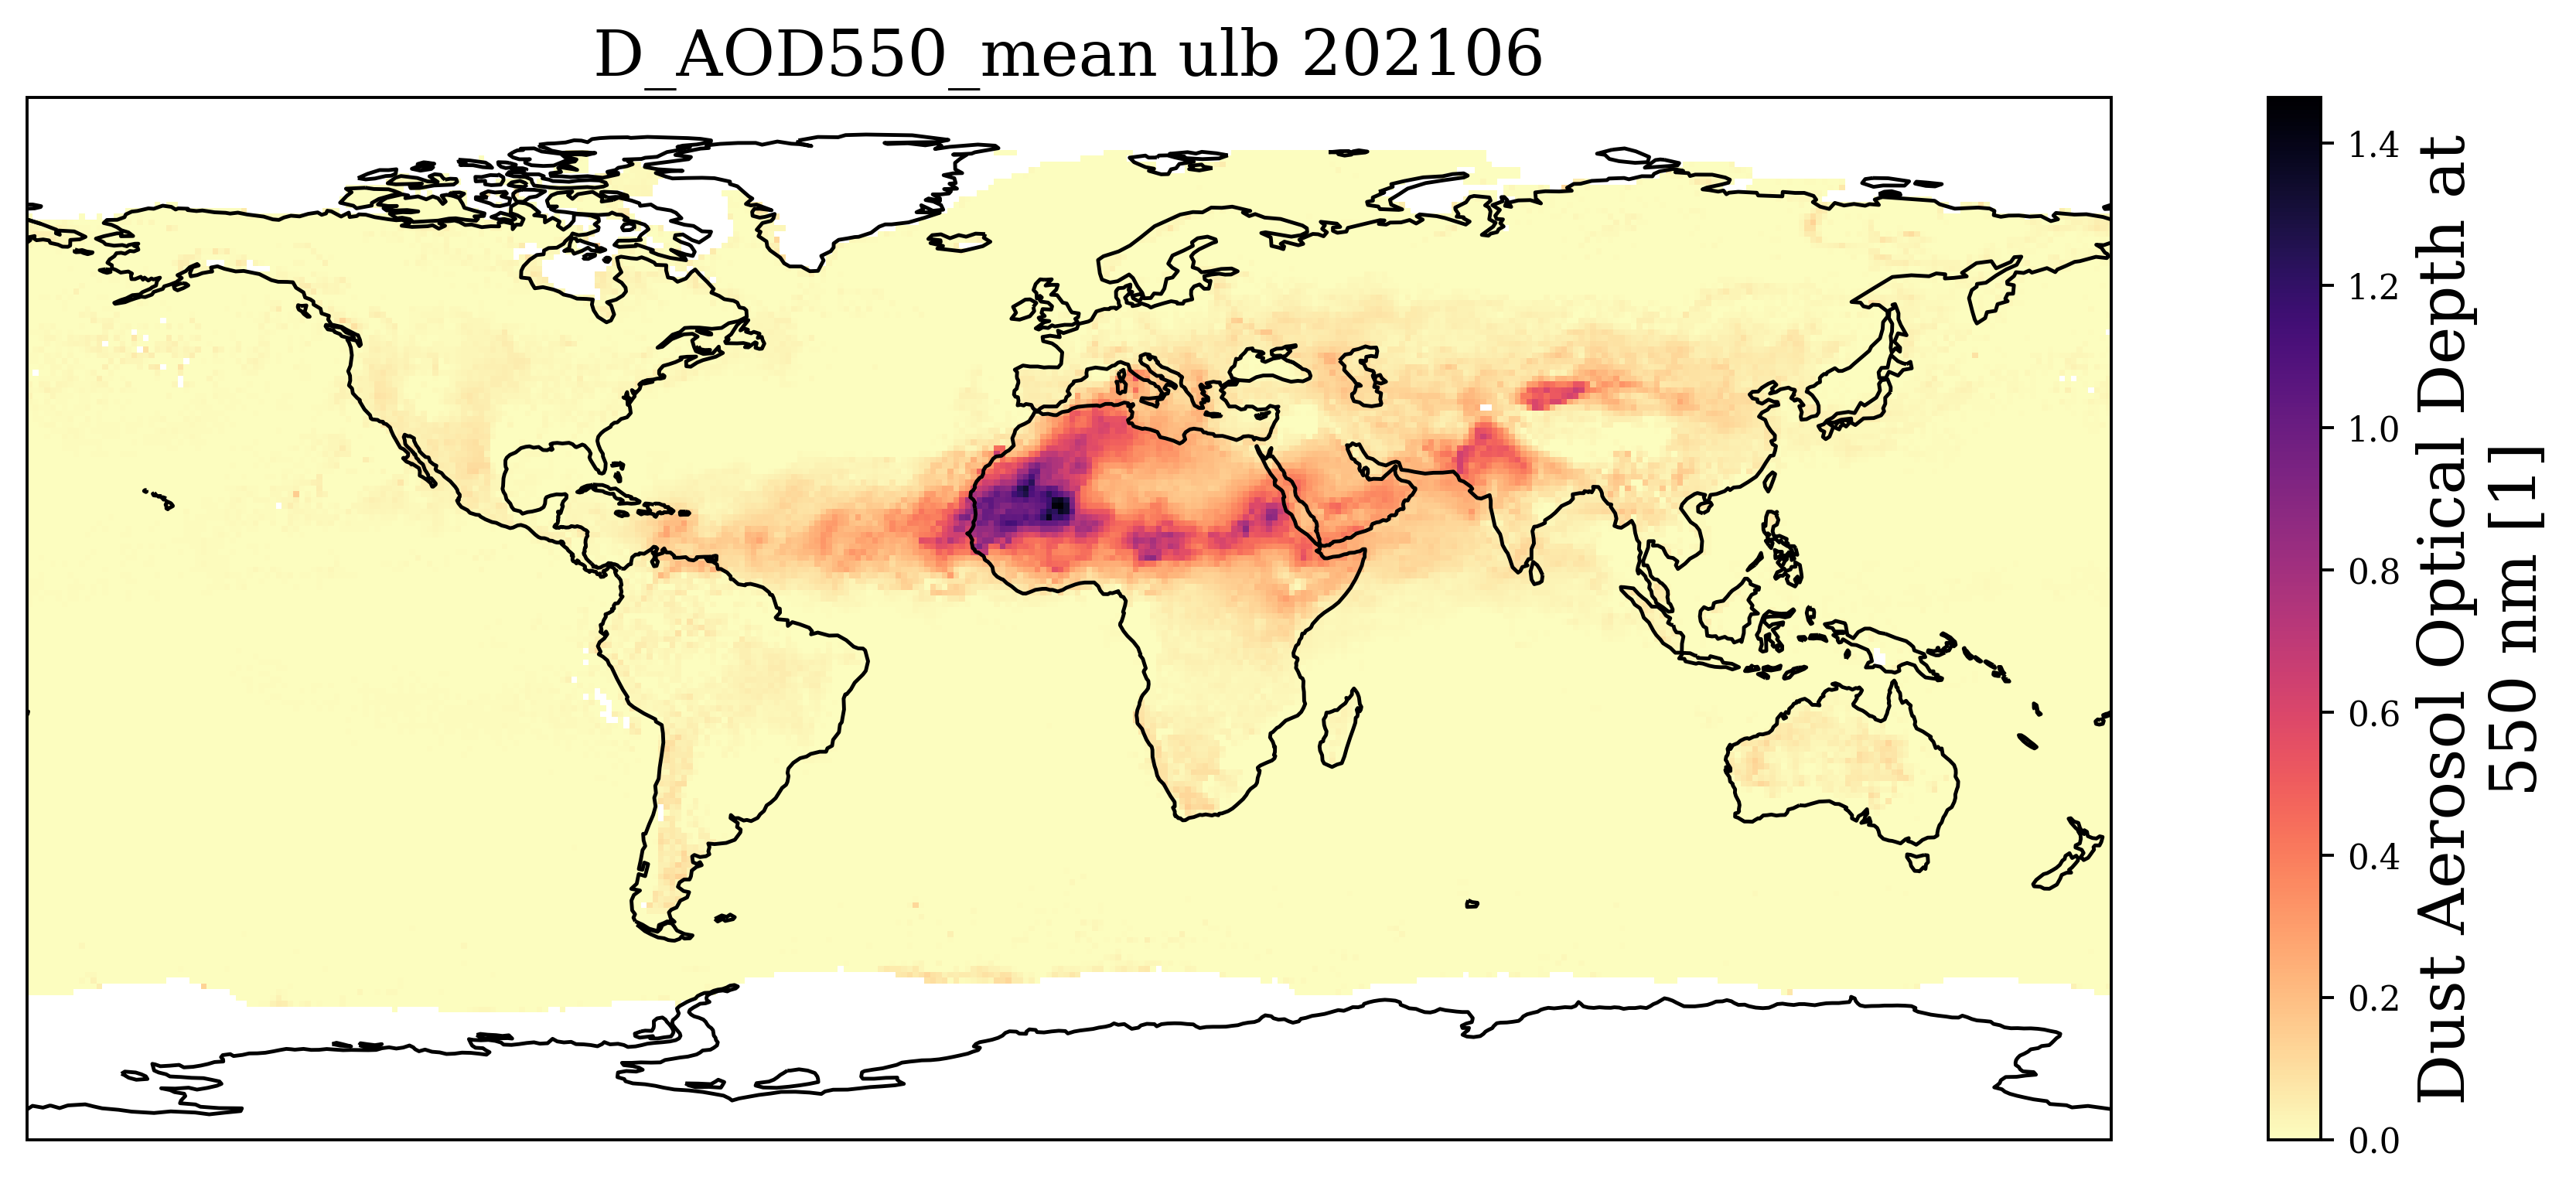

In [15]:
# Extract and plot the data
data = getattr(file, variable) # extracts the data of the choosen variable from the dataset
ax = plt.axes(projection=ccrs.PlateCarree()) # selects projection
ax.set_global()
data.plot(ax=ax, cmap='magma_r') # plot the data with the selected colormap
ax.coastlines() # plot the coastlines
title = variable + ' ' + algorithm + ' ' + filename[0:6]
plt.title(title) # write title
plt.savefig('./plots/'+title+'.png', dpi=500, bbox_inches='tight') # save the plot file


**FIGURE 1:** You can see here a typical global aerosol map with well-known features (depending on season and variable) such as the spring Sahara dust outflow over the Atlantic (Dust AOD), the autumn biomass burning in Southern Africa and the Amazonas (Fine Mode AOD), and several more.

# <a id='timeseries'></a> Use case 2: Regional time series

After looking at one example of a monthly time averaged global distribution, in the next step we further investigate the dataset. The single sensor aerosol datasets are up to 15 years long, so that another useful way of visualizing is a time series. We will calculate a regional time series, plot it, and discuss its features.

Here is a common definition for a set of areas with rather homogeneous aerosol properties and meaningful aerosol behaviour. Own regions can be easily defined the same way. 

In [16]:
# Definition of different regions to choose from

extent = { # 'Region' : [lon_min, lon_max, lat_min, lat_max],
            'Europe': [-15, 50, 36, 60],
            'Boreal': [-180, 180, 60, 85],
            'Asia_North': [50, 165, 40, 60],
            'Asia_East': [100, 130, 5, 41],
            'Asia_West': [50, 100, 5, 41],
            'China_South-East': [103, 135, 20, 41],
            'Australia': [100, 155, -45, -10],
            'Africa_North': [-17, 50, 12, 36], 
            'Africa_South': [-17, 50, -35, -12],
            'South_America': [-82, -35, -55, 5],
            'North_America_West': [-135, -100, 13, 60],
            'North_America_East': [-100, -55, 13, 60],
            'Indonesia': [90, 165, -10, 5],
            'Atlanti_Ocean_dust': [-47, -17, 5, 30],
            'Atlantic_Ocean_biomass_burnig': [-17, 9, -30, 5],
            'World': [-180, 180, -90, 90],
            'Asia': [50, 165, 5, 60],
            'North_America': [-135, -55, 13, 60], 
            'dust_belt': [-80, 120, 0, 40], 
            'India': [70, 90, 8, 32], 
            'Northern_Hemisphere': [-180, 180, 0, 90], 
            'Southern_Hemisphere': [-180, 180, -90, 0],
            }

We now choose one region and set the minimum required coverage (fraction of years with valid data in a month) for the time series. 

In [17]:
# Select a region for the analysis

# for the example datasets downloaded, we suggest the folloiwng regions
#1 region = 'Europe'
region = 'dust_belt'
#3 region = 'Africa_South'
#4 region = 'Southern_Hemisphere'


In [18]:
# Select a minimal required coverage 
min_coverage = 0.5

Then we combine the datasets in one xarray dataset. 

In [19]:
# Combine the datasets in one xarray dataset
files = os.listdir(dir)
file_list = []
time = []
for file in files:
    path = dir + file
    if os.path.isfile(path):
        time_element = datetime.datetime.fromisoformat(file[0:4] + '-' + file[4:6] + '-15')
        time.append(time_element)
        file_coll = xr.open_dataset(path)
        file_list.append(file_coll)
dataset = xr.concat(file_list, dim=xr.DataArray(time, dims='time'))

# if you want to list all variables, just uncomment the following line
# dataset # show xarray dataset 

Then we can plot the timeseries.

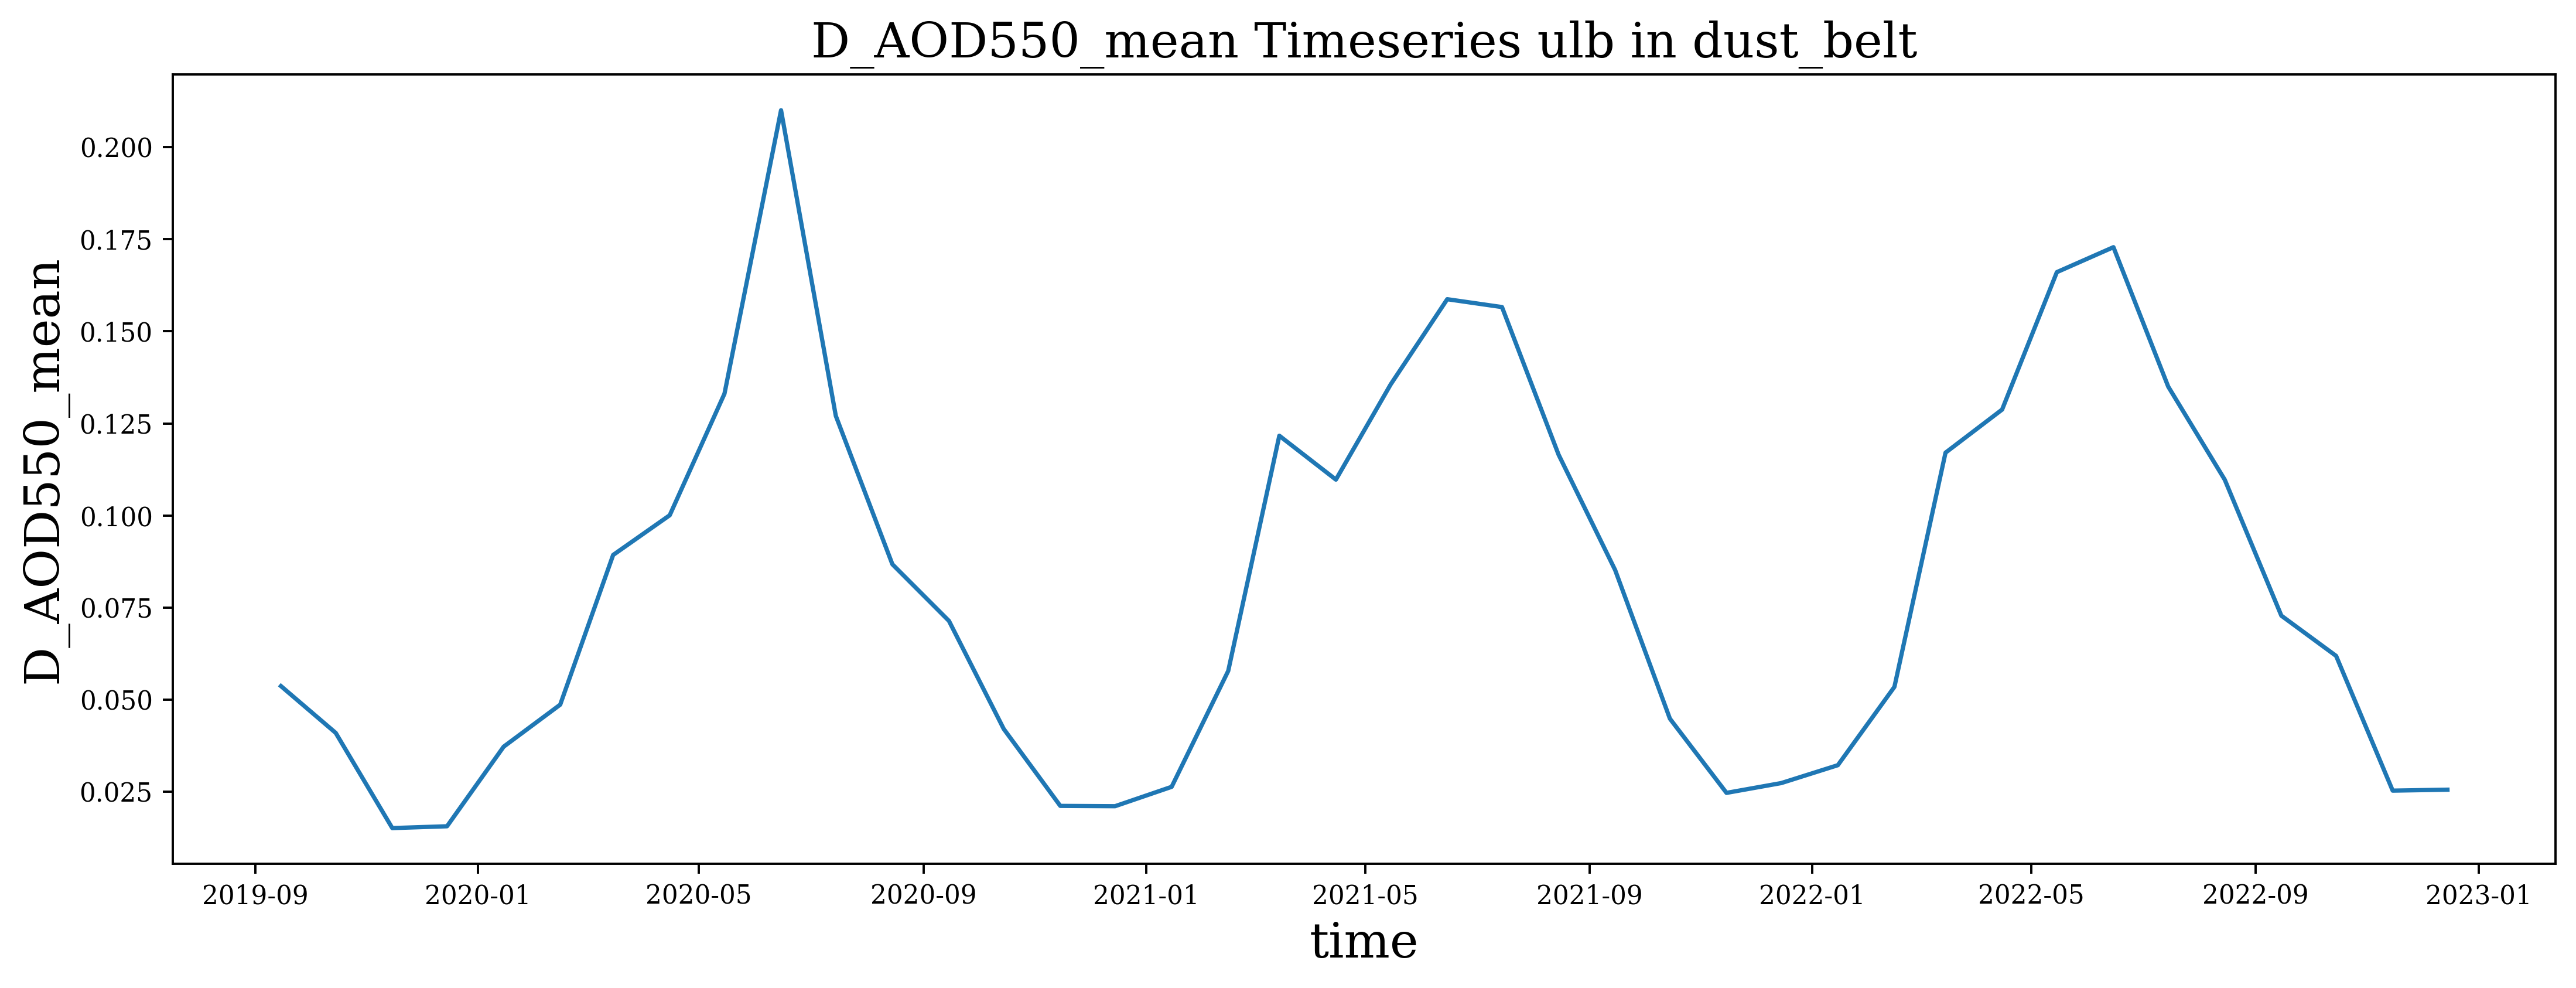

In [20]:
# Plot the time series

data = getattr(dataset, variable).sel(
    latitude=slice(extent[region][2], extent[region][3]),   # select latitude 
    longitude=slice(extent[region][0], extent[region][1])   # select longitude 
    ).mean(dim=["latitude", "longitude"])                   # calculate the mean along the latitude and longitude axis
data.plot()
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # change the shown dateformat on the x-axis
plt.title(variable + ' Timeseries ' + algorithm + ' in ' + region)
plt.savefig(PLOTDIR + 'timeseries_' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')

**FIGURE 2:** Such an aerosol time series typically shows a more or less obvious annual cycle related to the annual cycle of the relevant sources and meteorological conditions. In some years and regions exceptional peaks may be seen.

# <a id='climatology'></a> Use case 3: "Climatology" (multi-annual mean) and anomaly - maps and time series

In the next step we further investigate the dataset by comparing the data of individual months to a longer-term mean state (multi-annual mean or "climatology" if of sufficient length).

We define the sub directory in which the climatology data will be stored.

Note that the following code blocks are not yet prepared for the stratospheric aerosol extinction profiles.

In [21]:
# Create a sub directory for the climatology

if not os.path.exists(dir + '/climatology'):
    os.makedirs(dir + '/climatology')
dir_clima = dir + '/climatology/'

We set the minimum required number of years with valid data.

In [22]:
# Calculate the minimum number of years with valid data required by the fraction defined above for minimum temporal coverage.
min_years = len(years) * min_coverage
print(min_years)


2.0


Then, we calculate the mean of all years per calendar month and the standard deviation for each lat-lon cell, where the required minimum of years has valid data and store them in one NetCDF4 file per calendar month. 

In [23]:
# Calculate the climatology (mean and standard deviation of all years included into the dataset)

for month in months:
    data_list = []
    for year in years:
        t = str(year) + str(month)
        for file in files:
            if t in file:
                titel = file
                path = dir + titel
                file = xr.open_dataset(path) # open each file with xarray
                data = getattr(file, variable)
                data_list.append(data)
    # calculate mean and stdv per month
    data_month = xr.concat(data_list, dim='year') # combine the datasets into one xarray dataset
    data_mean_month = xr.where(data_month.count(dim='year')>=min_years, data_month.mean(skipna = True, dim='year'), np.nan)
    data_std_month = xr.where(data_month.count(dim='year')>=min_years, data_month.std(skipna = True, dim='year'), np.nan)

#Create a NetCDF4 File with the climatology data and their standard deviation

    fpath= f'{dir_clima}/climatology_' + month + '.nc' # definition of new filename
    climatology_dataset = xr.Dataset({variable:data_mean_month, variable+'_std':data_std_month})
    climatology_dataset.to_netcdf(fpath, format='NETCDF4')    
    



/home/scheiner1/hpopp/C3S_jupyter_notebook/new21102024/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/scheiner1/hpopp/C3S_jupyter_notebook/new21102024/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/scheiner1/hpopp/C3S_jupyter_notebook/new21102024/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/scheiner1/hpopp/C3S_jupyter_notebook/new21102024/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/scheiner1/hpopp/C3S_jupyter_no

### Open NetCDF4 File and plot climatology map for selected calendar month

We select one calendar month, read its netCDF file and prepare the monthly multi-annual mean map.

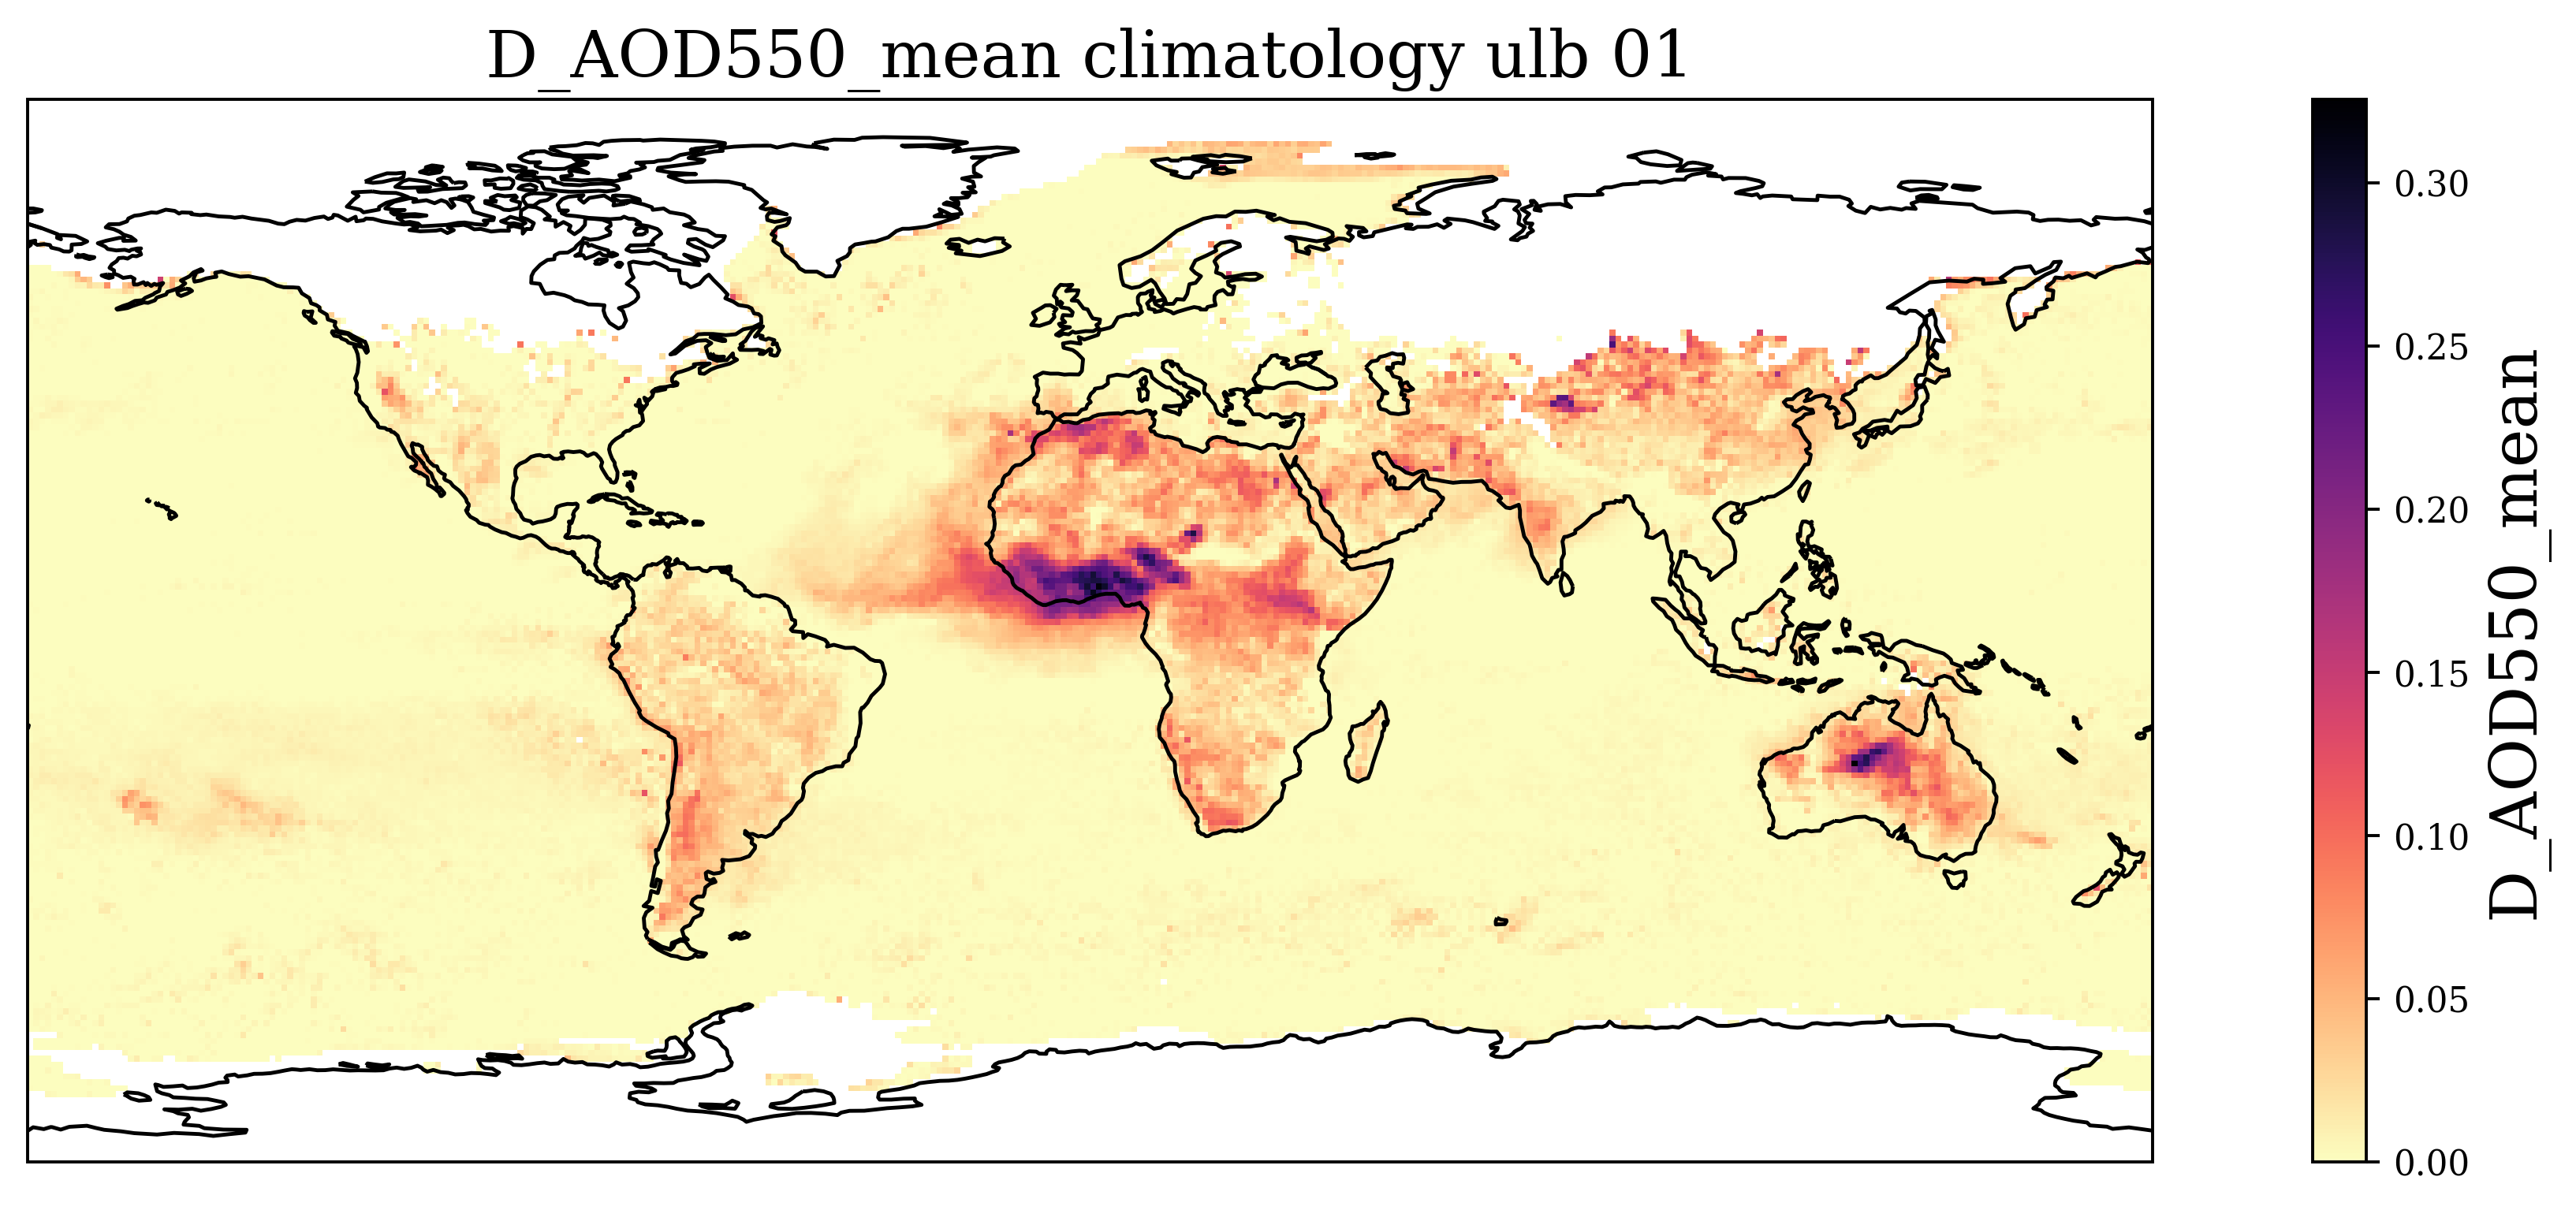

In [24]:
# Select one calendar month for a plot
month = '01'

# Read the netCDF file
path = f'{dir_clima}climatology_' + month + '.nc'
file = xr.open_dataset(path)
data = getattr(file, variable)

# Plot the climatology map for the selected month
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
data.plot(ax=ax, cmap='magma_r')
ax.coastlines()
file.close()

plt.title(variable + ' climatology ' + algorithm + ' ' + month)
plt.savefig(PLOTDIR + 'map_climatology_' + variable + '_' + algorithm + '_' + month + '.png', dpi=500, bbox_inches='tight')

**FIGURE 3:** This figure shows (similar to the example monthly mean map above) those typical aerosol features which occur in the selected calendar month, but now averaged over several years and thus showing a multi-annual mean state of the atmosphere in that calendar month.

### Regional climatology: calculate and plot as time series


For the region and variable as selected above and the full timerange used for the multi-annual mean, we calculate now regional averages of the climatology in each calendar month and of each invidual month in the time series. We also calculate the standard deviation for each calendar month as measure of the multi-annual variability.

In [26]:
# Calculate the monthly climatology of regional values (mean, standard deviation) from all downloaded years

files_clima = os.listdir(dir_clima)
year = []
climatology = []
sdev = []

for month in months:
    t = str(month)
    for file in files_clima:
        if t in file:
            path = dir_clima + file
            file = xr.open_dataset(path)
            data = getattr(file, variable).sel(
                latitude=slice(extent[region][2], extent[region][3]), 
                longitude=slice(extent[region][0], extent[region][1]))
            var_data = float(data.mean(skipna = True))
            data_std = getattr(file, variable+'_std').sel(
                latitude=slice(extent[region][2], extent[region][3]), 
                longitude=slice(extent[region][0], extent[region][1]))
            var_data_std = float(data_std.mean(skipna = True))
            climatology.append(var_data)
            sdev.append(var_data_std)
            year.append(int(month))
            file.close()

Plot "climatology" and its standard deviation

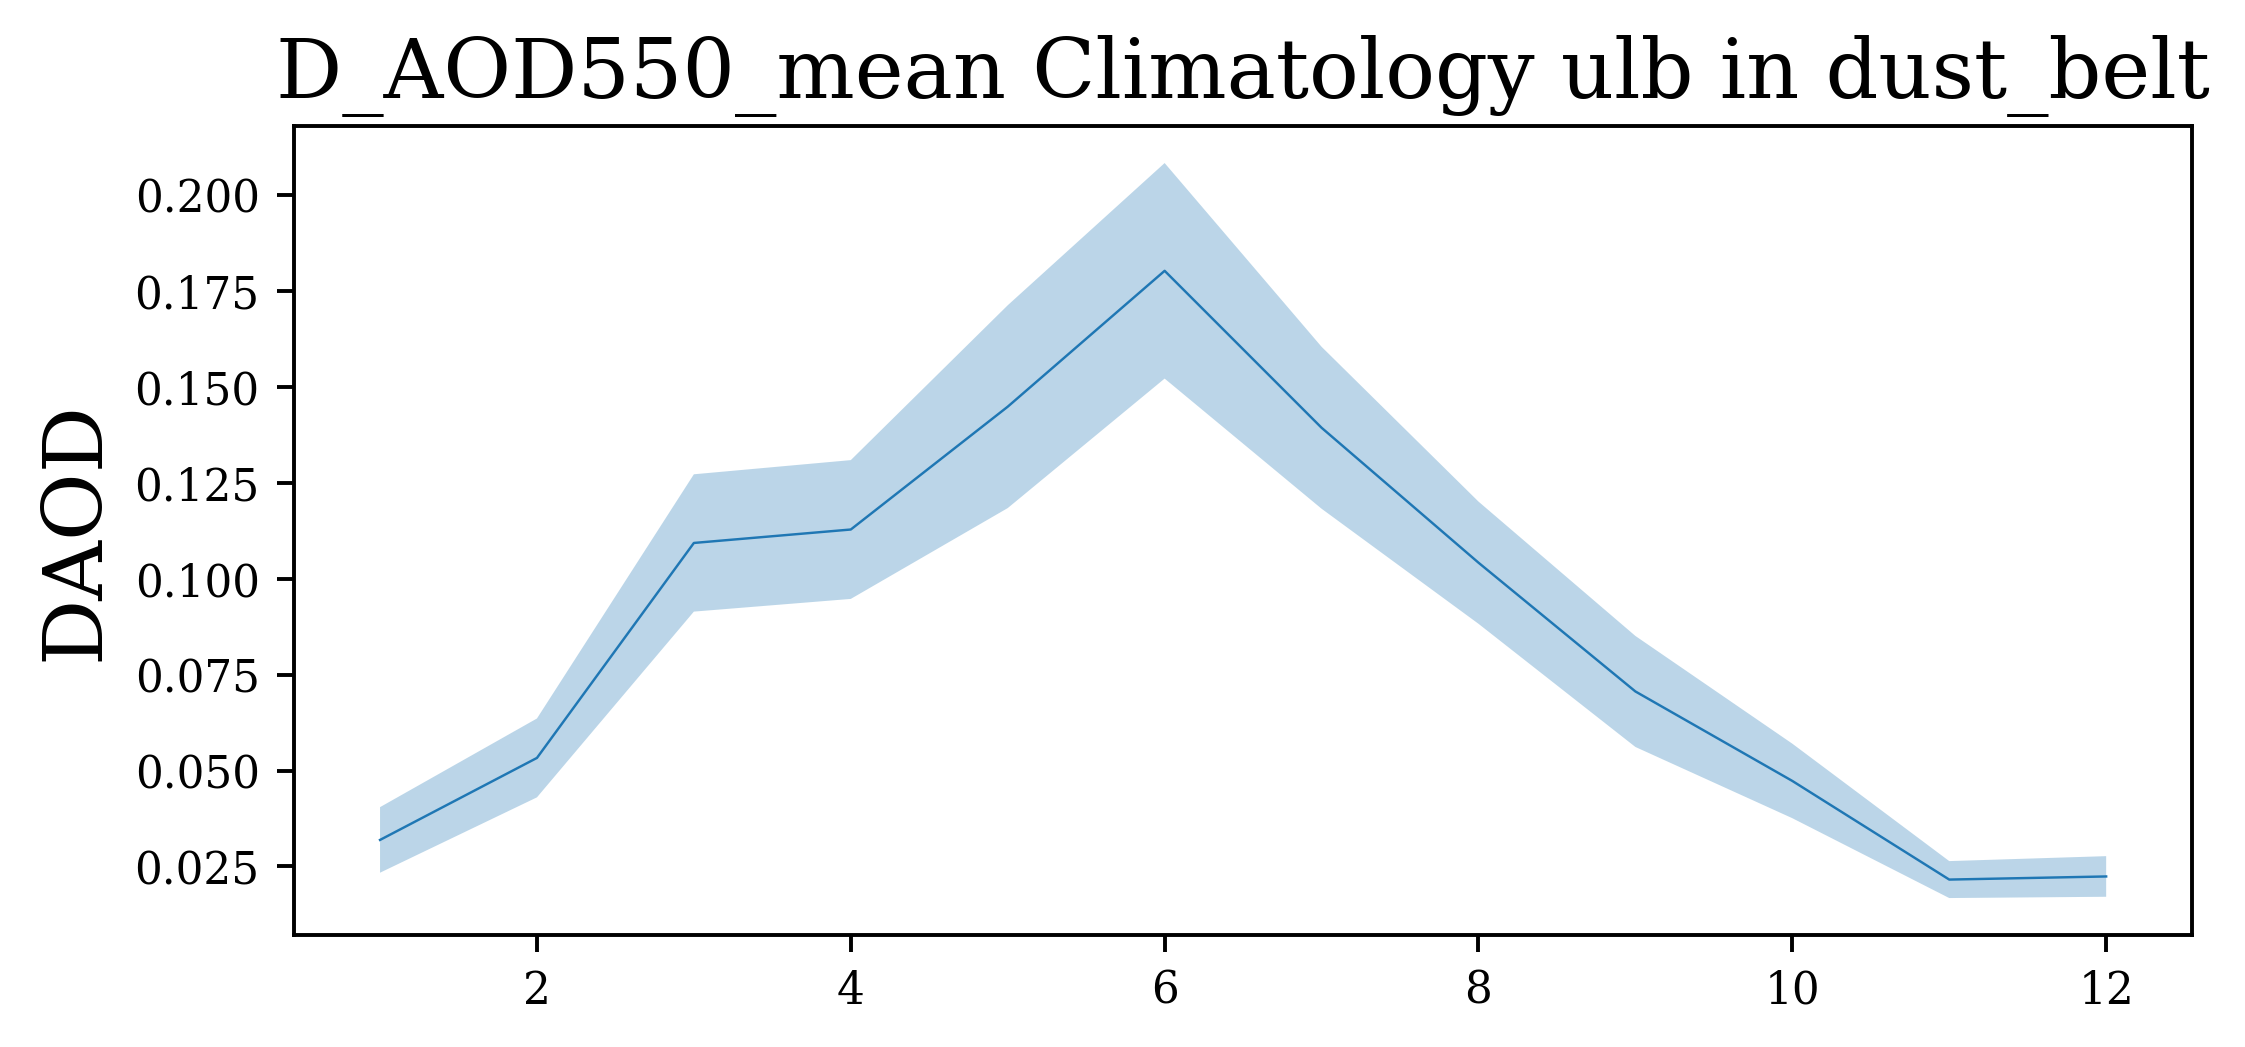

In [27]:
# Define the variability range (+/- half a standard deviation) or each month in the regional climatology
sdev_p = [climatology[i] + 0.5*sdev[i] for i in range(len(climatology))] 
sdev_m = [climatology[i] - 0.5*sdev[i] for i in range(len(climatology))]

# Plot the annual climatology and its variabiloity range (shaded)
fig = plt.figure(figsize=(7,3))
plt.fill_between(year, sdev_p, sdev_m, alpha = 0.3)
plt.plot(year, climatology, '-', label = variable, linewidth = 0.5)

# Select the label (for all possible variable names)
if variable[0:3] == 'AOD': # Total AOD
    plt.ylabel("AOD")
if variable[0:2] == 'DA' or variable[0:2] == 'Da' or variable[0:5] == 'D_AOD': # Dust AOD
    plt.ylabel("DAOD")
if variable[0:2] == 'FM': # Fine Mode AOD
        plt.ylabel("FM_AOD")
if variable[0:1] == 'S': # single scattering albedo
        plt.ylabel("SSA")
if variable[5:9] == 'dust' or variable[2:5] == 'ALT': # Dust Altitude
        plt.ylabel("DALH")
                
plt.title(variable + ' Climatology ' + algorithm + ' in ' + region)
plt.savefig(PLOTDIR + 'annual_climatology_' + variable + '_' + algorithm + '_' + region +'.png', dpi=500, bbox_inches='tight')

**FIGURE 4:** The figure shows now the average annual cycle in the selected region extracted from the multi-annual dataset.

### Plot timeseries with climatology

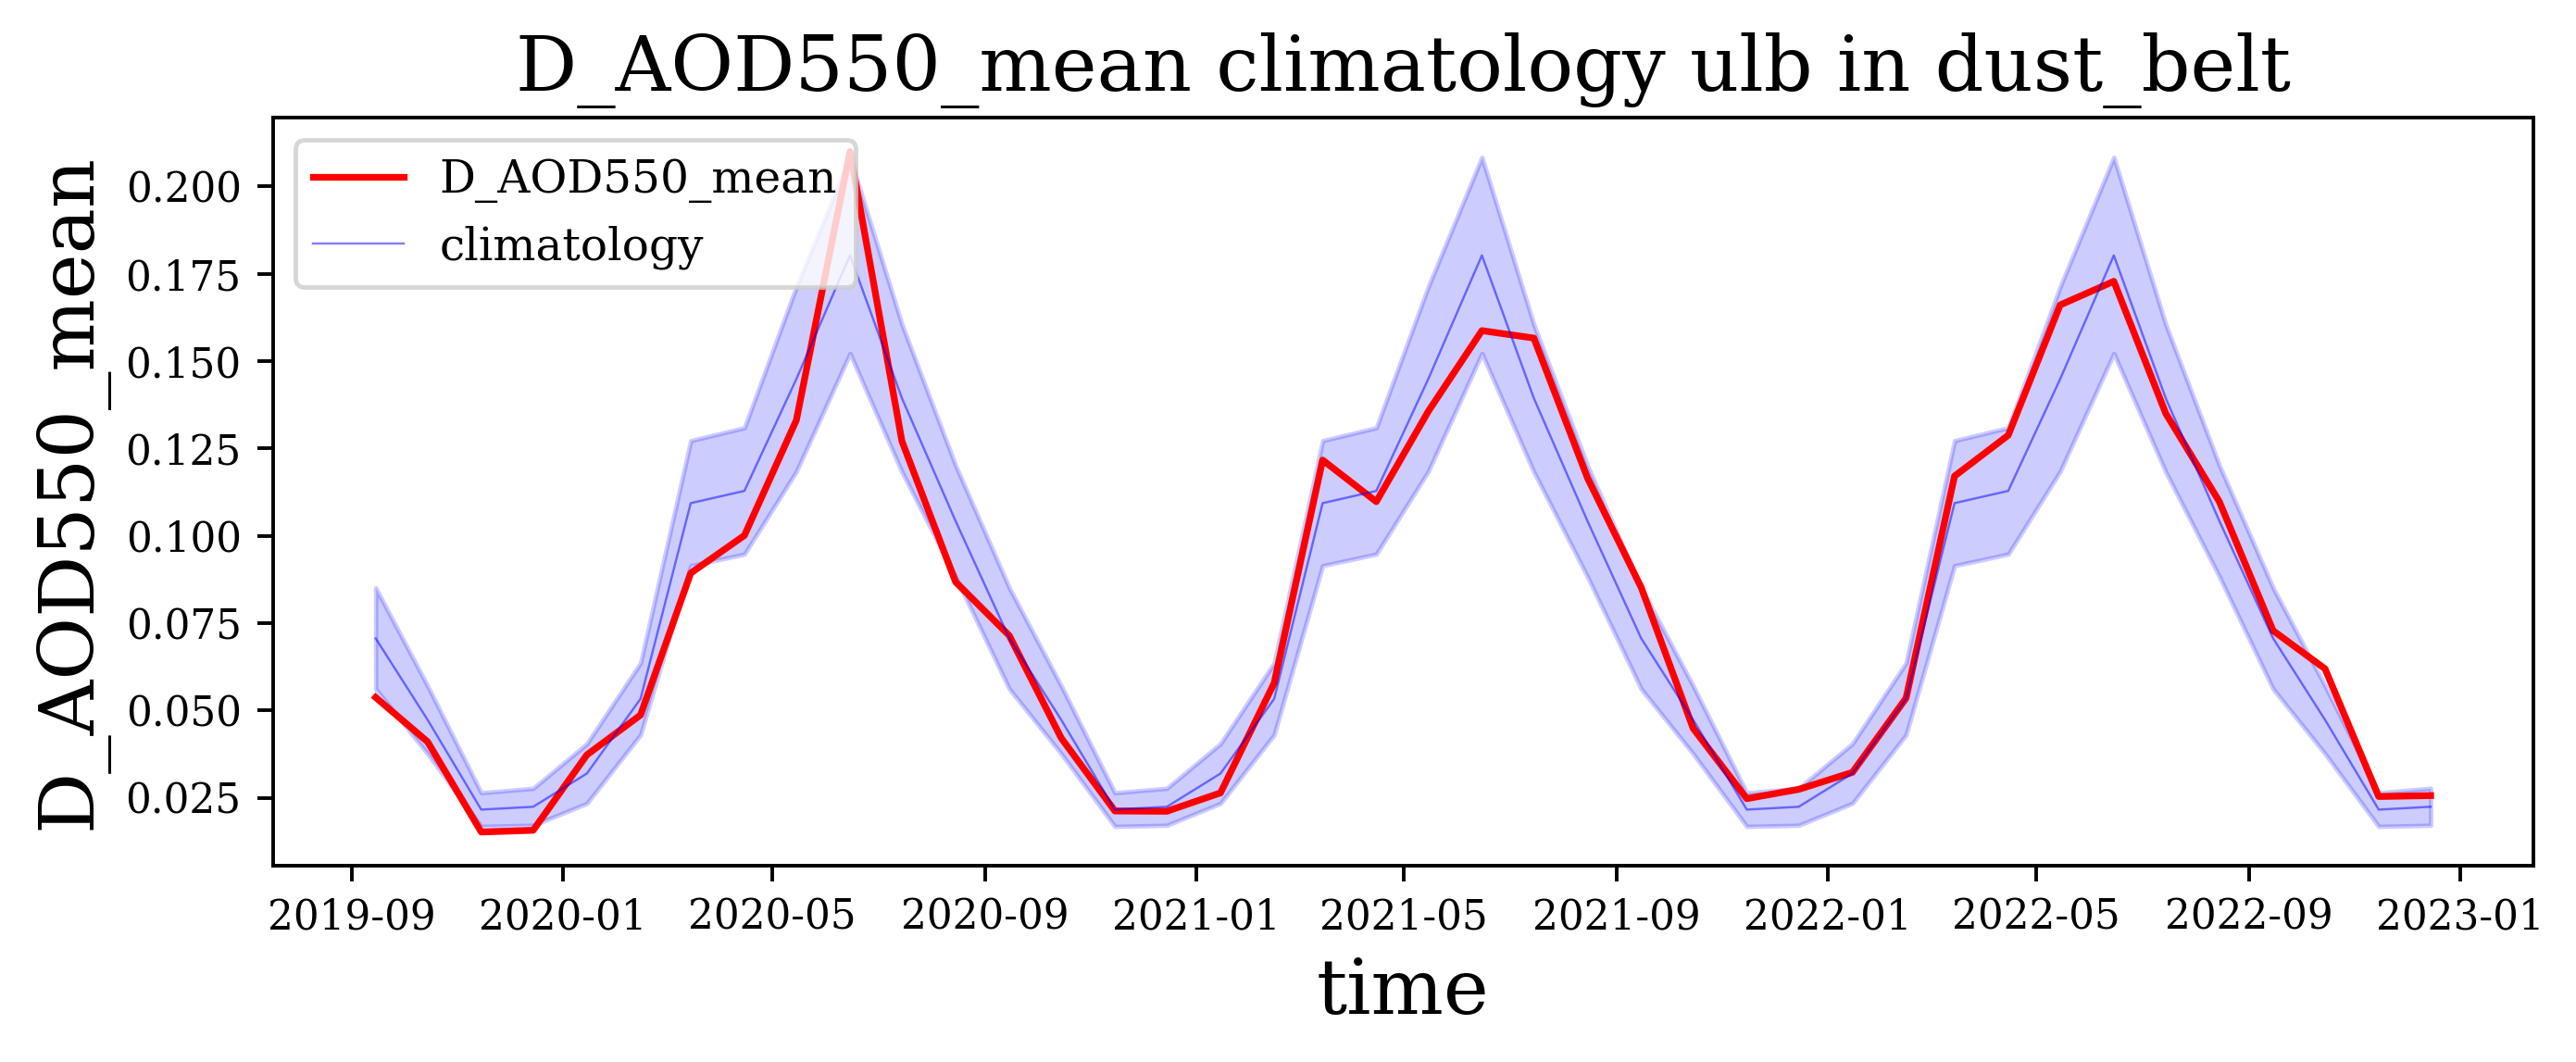

In [28]:
# Now, we overplot the multi-annual regional time series with the averaged climatolog of those years

fig = plt.figure(figsize=(9,3))

data = getattr(dataset, variable).sel(
    latitude=slice(extent[region][2], extent[region][3]),   # select latitude 
    longitude=slice(extent[region][0], extent[region][1])   # select longitude 
    ).mean(dim=["latitude", "longitude"])                   # calculate the mean along the latitude and longitude axis
data.plot(color='red', label=variable)
times = np.datetime_as_string(data.time.data, unit='M')

files_clima = os.listdir(dir_clima)

climatology = []
sdev = []
time = []
for t in times:
    
    time.append(datetime.datetime.fromisoformat(t + '-15'))
    
    path = dir_clima + 'climatology_' +  t[5:7]+ '.nc'
    file = xr.open_dataset(path)
    data_mean = getattr(file, variable).sel(
        latitude=slice(extent[region][2], extent[region][3]), 
        longitude=slice(extent[region][0], extent[region][1]))
    var_data = float(data_mean.mean(skipna = True))
    data_std = getattr(file, variable+'_std').sel(
        latitude=slice(extent[region][2], extent[region][3]), 
        longitude=slice(extent[region][0], extent[region][1]))
    var_data_std = float(data_std.mean(skipna = True))
    climatology.append(var_data)
    sdev.append(var_data_std)
    file.close()
            
sdev_p = list(np.array(climatology)+0.5*np.array(sdev))
sdev_m = list(np.array(climatology)-0.5*np.array(sdev))

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # change the shown dateformat on the x-axis

plt.fill_between(time, sdev_p, sdev_m, color = 'blue', alpha = 0.2)
plt.plot(time, climatology, '-', label = 'climatology', color = 'blue', linewidth = 0.5, alpha = 0.5)
                
plt.legend(loc='upper left')
plt.title(variable + ' climatology ' + algorithm + ' in ' + region)
plt.savefig(PLOTDIR + 'timeseries_with_climatology_' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')

**FIGURE 5:** The next figure shows the time series in red compared to the multiannual mean in blue and its standard deviation in light blue shading (both repeated from year to year). Exceptional episodes stand out if the red line breaks out of the blue shade.

### Anomaly time series

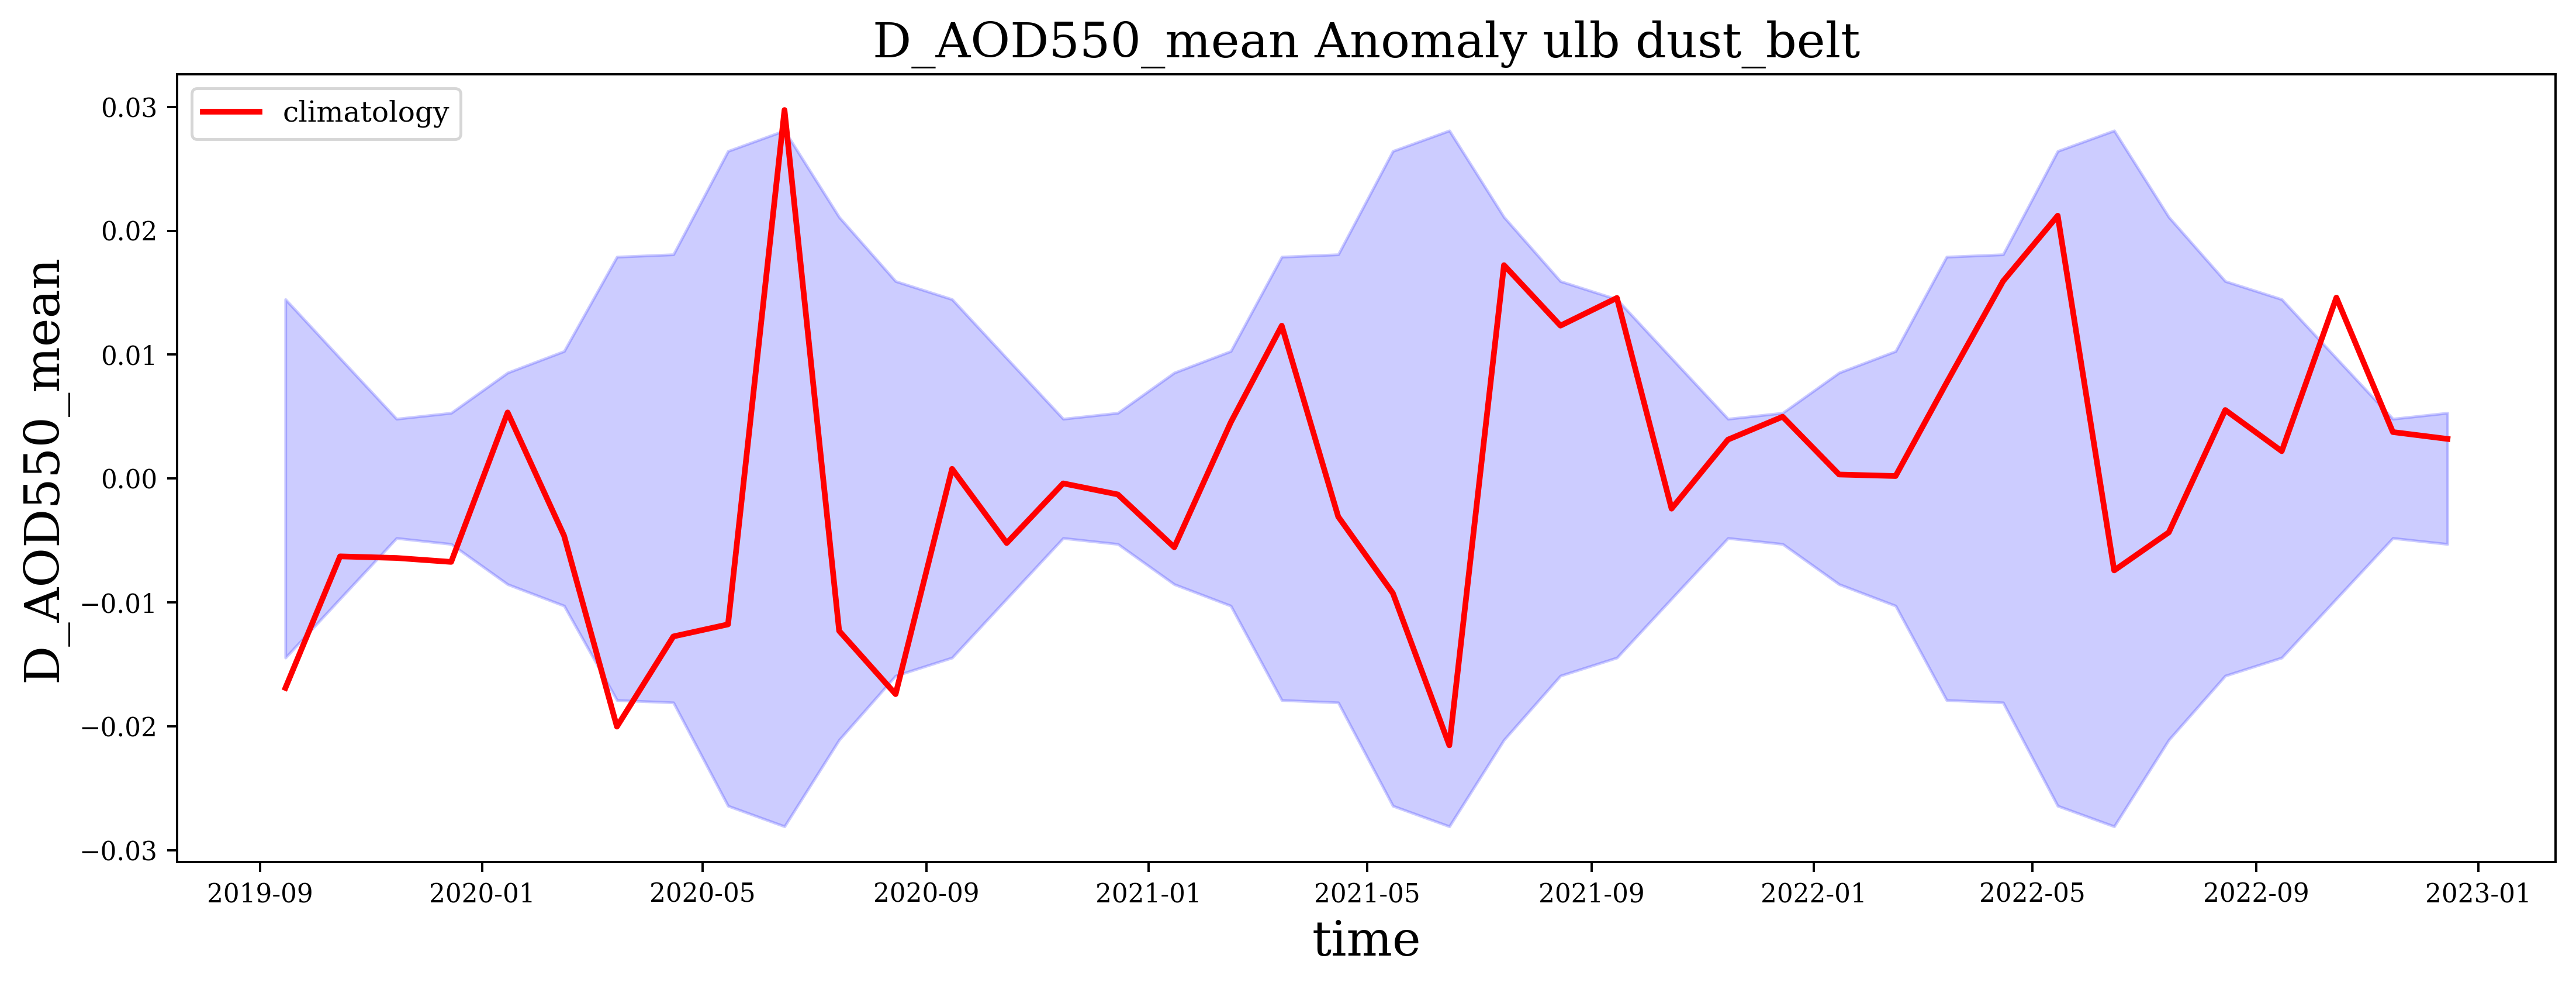

In [29]:
# Finally, we overplot the anomaly (= difference from the multi-annual averaged climatology) over the variability range of the data.

anomaly = data - climatology     
sdev_p = list(+0.5*np.array(sdev))
sdev_m = list(-0.5*np.array(sdev))

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # change the shown dateformat on the x-axis

plt.fill_between(time, sdev_p, sdev_m, color = 'blue', alpha = 0.2)
plt.plot(time, anomaly, '-', label = 'climatology', color = 'red', linewidth = 2)
plt.ylabel(variable)
plt.xlabel('time')
plt.legend(loc='upper left') 
plt.title(variable + ' Anomaly ' + algorithm + ' ' + region)
plt.savefig(PLOTDIR + 'anomaly_timeseries__' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')

**FIGURE 6:** This final regional time series plot shows the data record in the form of anomalies, i.e. differences between individual monthly data points and the multi-annual monthly mean compared to the multi-annual monthly variations around the zero anomaly line.

# <a id='vertical'></a> Use Case 4: Visualize Vertical Profile data


As a last example we present a completely different dataset: vertical profiles obtained with the GOMOS star occultation spectrometer (Aergom algorithm).
For each observation the instrument needs to point to a star with sufficient brightness for the occultation measurement. Conceqeuntly, the observations are very sparse and not sufficient for daily mapping.
In response to user needs to allow identifying short-term and small-scale volcanic episodes, this dataset has a special temporal and spatial resolution: Temporally, it is provided as 5-daily averages (not as monthly or daily means). Spatially, it is provided for grid boxes of 60 degrees in longitude and 5 degrees in latitude since emissions from volcanic eruptions disperse along latitude bands in the stratosphere.
Consequently, the download sequence needs to query each calendar day to find and download the 5-daily files.

In [34]:
# Download GOMOS data: AERGOM algorithm, aerosol extinction profiles

# Define specific sub directory for the GOMOS data
if not os.path.exists(DATADIR + 'GOMOS'):
    os.mkdir(DATADIR + 'GOMOS')

# Specify the characteristics of the data for downloading: variable, year(s), month(s), all days per month
# if you want to download the full data record, use the codes behind the #
# However, for downloading the entire 10 years of data with daily queries, the notebook will take a long time.
variable = 'aerosol_extinction_coefficient'
years = ['2008'] # years = ['%02d'%(year) for year in range('2002', '2012')]
months = ['07'] # months = ['%02d'%(month) for month in range(1, 13)]
days = ['%02d'%(day) for day in range(1, 32)]

# download the specified GOMOS data from the CDS
c = cdsapi.Client(url=URL, key=KEY)
product='satellite-aerosol-properties'
countdays = 0
count_nodata = 0
for year in years:
    for month in months:
        for day in days:
            countdays = countdays + 1
            try:
                request = {
                        'time_aggregation': '5_daily_composite',
                        'variable': variable,
                        'sensor_on_satellite': "gomos_on_envisat",
                        'algorithm': "aergom",
                        'year': year, 
                        'month': month,
                        'day': day,
                        'version': ["v4_01s"]}
                file_name = DATADIR + 'GOMOS/aergom_' + str(year) + '_' + str(month) + '_' + str(day) + '.zip'
                c.retrieve(product, request, file_name)
                print('downloaded: ' + year + '-' + month + '-' + day)
            except:
                # print('no data ' + year + '-' + month + '-' + day)
                count_nodata = count_nodata + 1

print('downloaded days: ',countdays - count_nodata)


2024-11-06 16:21:19,934 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-06 16:21:19,935 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informative page](https://confluence.ecmwf.int/x/uINmFw) for guidance.
2024-11-06 16:21:19,935 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-06 16:21:19,936 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-06 16:21:19,936 WARNING [2024-06-16T

downloaded: 2008-07-03


2024-11-06 16:21:44,536 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-06 16:21:44,537 INFO Request ID is 56cfe76e-37c1-421b-b92b-d4d878a8bdb1
2024-11-06 16:21:44,643 INFO status has been updated to accepted
2024-11-06 16:22:44,918 INFO status has been updated to successful


downloaded: 2008-07-08


2024-11-06 16:22:58,202 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-06 16:22:58,204 INFO Request ID is 86fd2dcd-4e84-463e-beab-c5e4cc4c3acf
2024-11-06 16:22:58,252 INFO status has been updated to accepted
2024-11-06 16:23:06,239 INFO status has been updated to running
2024-11-06 16:23:11,989 INFO status has been updated to successful


downloaded: 2008-07-13


2024-11-06 16:23:22,245 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-06 16:23:22,246 INFO Request ID is 70f7f7be-75ed-447d-adb5-9b5c8bc21b1e
2024-11-06 16:23:24,459 INFO status has been updated to accepted
2024-11-06 16:23:40,272 INFO status has been updated to successful


downloaded: 2008-07-18


2024-11-06 16:23:47,648 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-06 16:23:47,649 INFO Request ID is cfb19b4a-3d86-4707-94e1-b972af9c2622
2024-11-06 16:23:47,834 INFO status has been updated to accepted
2024-11-06 16:23:52,759 INFO status has been updated to running
2024-11-06 16:23:56,203 INFO status has been updated to successful


downloaded: 2008-07-23


2024-11-06 16:24:04,790 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-06 16:24:04,791 INFO Request ID is b69a991e-c5a4-41a1-8e2d-989ffd9418cd
2024-11-06 16:24:05,371 INFO status has been updated to accepted
2024-11-06 16:24:10,674 INFO status has been updated to running
2024-11-06 16:24:14,181 INFO status has been updated to successful


downloaded: 2008-07-28
downloaded days:  6


Extract the GOMOS data.

In [35]:
# "Define the GOMSO data directory and extract a list of downloaded files
dir = DATADIR+'GOMOS/'
files = os.listdir(dir)
# dir = f'{DATADIR}' + 'GOMOS/data/'

for file in files:
    if '.zip' in file:
        with zipfile.ZipFile(dir + file, 'r') as zip_ref:
            zip_ref.extractall(dir+'/data')
        os.remove(DATADIR + 'GOMOS/'+ file)
    

Select a dataset.
You can choose one of the days that have been reported as downloaded above.

In [45]:
# define filename and open the netCDF file
filename = '20080703-C3S-L3_AEROSOL-AER_PRODUCTS-GOMOS-ENVISAT-AERGOM-5DAILY-v4.01s.nc'
path = dir + '/data/' + filename
file = xr.open_dataset(path)
# if you want to list all variables, just uncomment the following line
# file

Plot a map at a choosen altitude.
For the AERGOM GOMOS vertical extinction profiles, you can select one vertical layer number and then plot a global map of this layer.

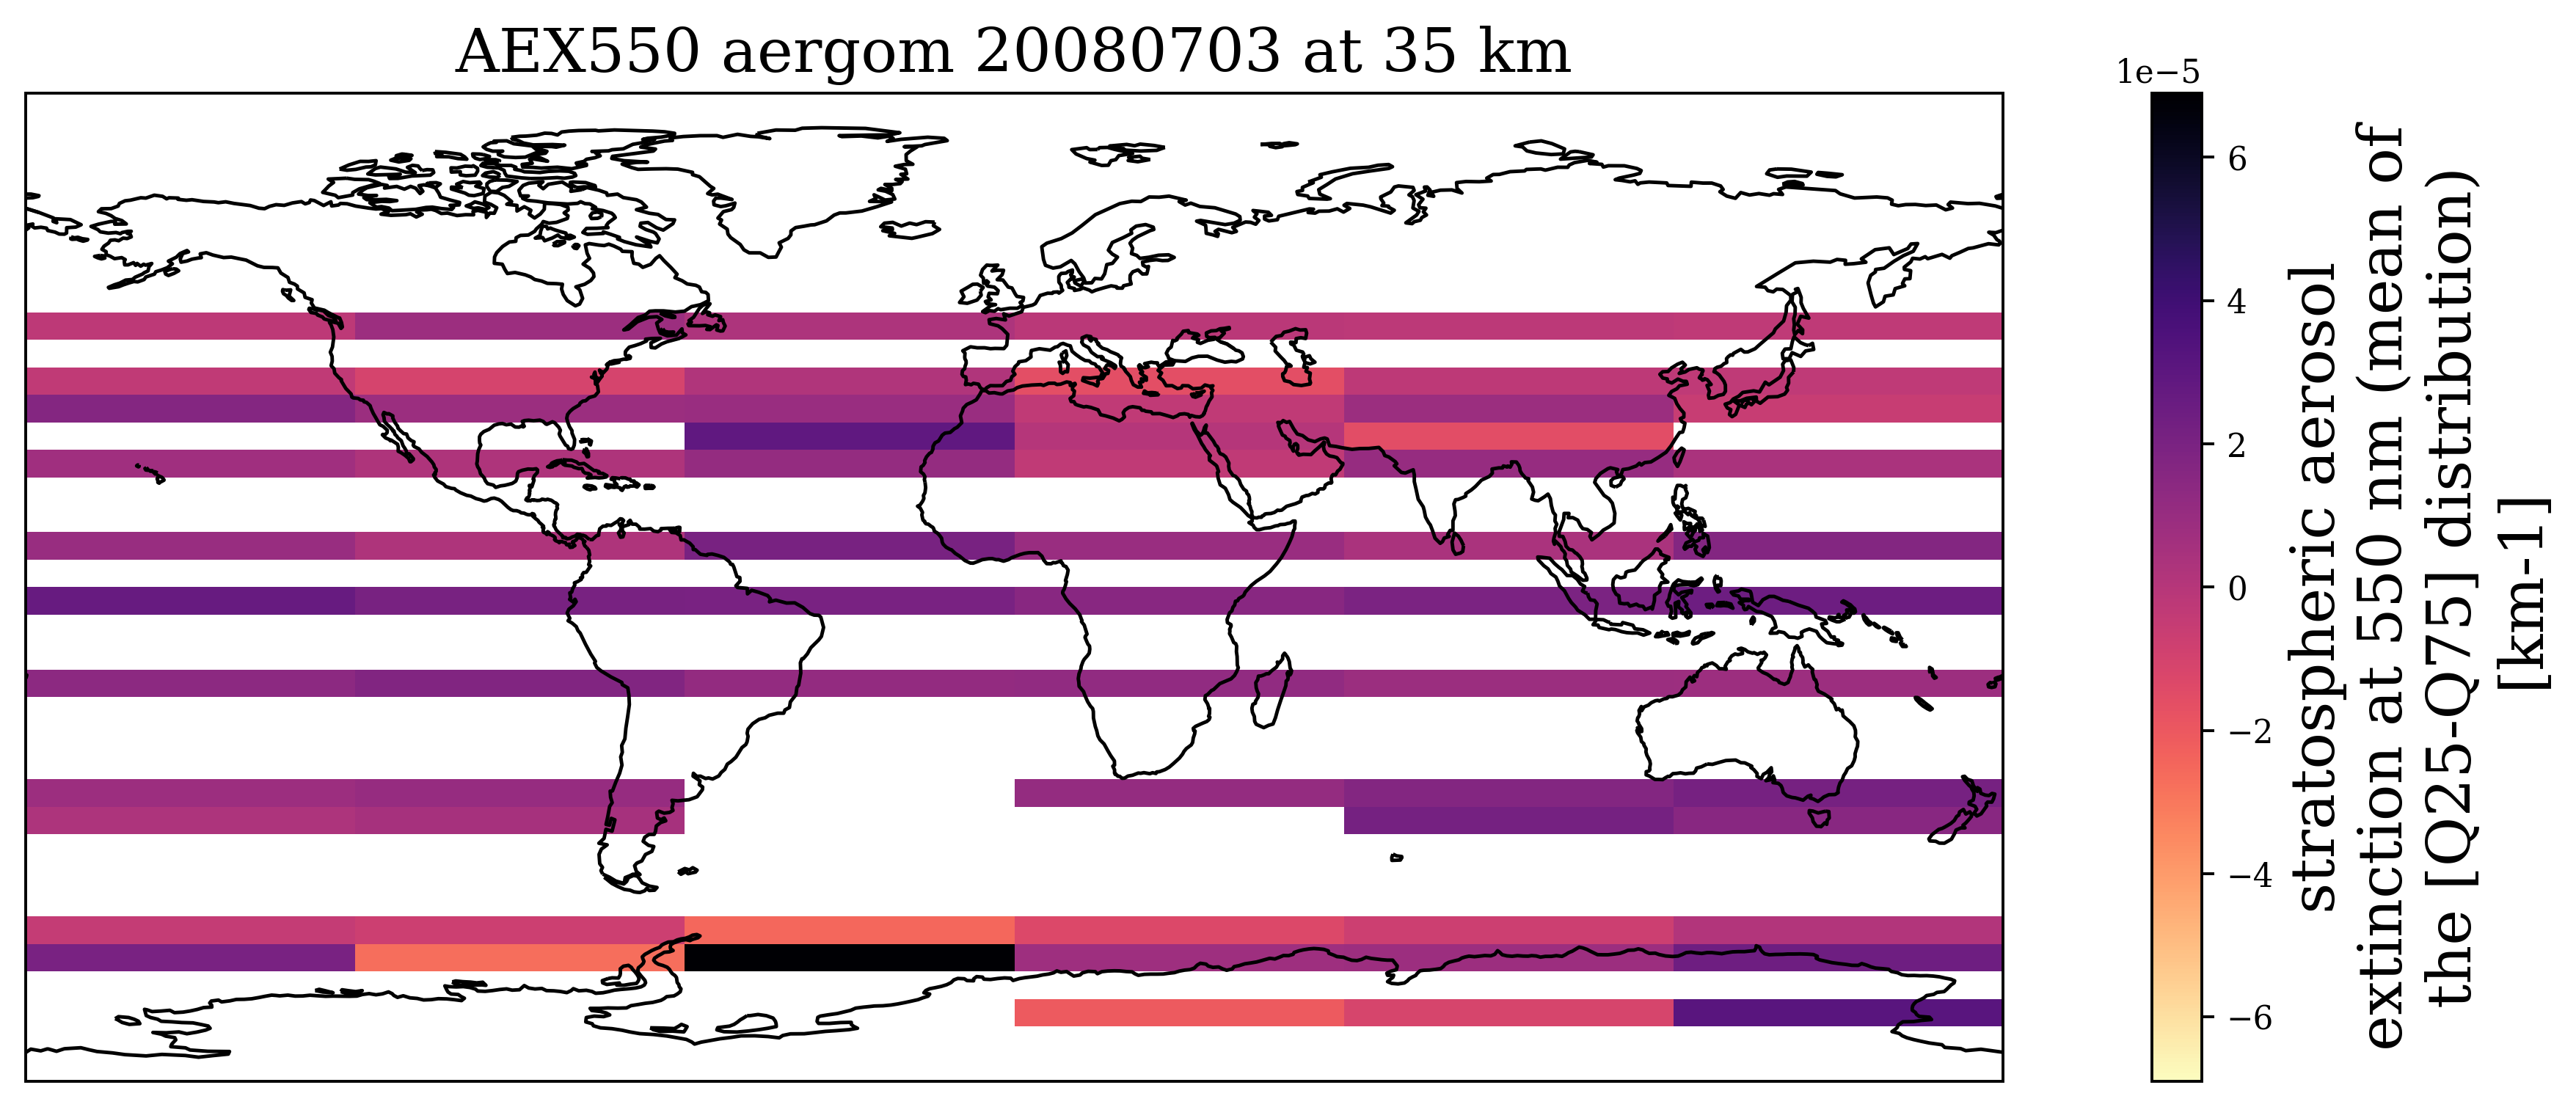

In [47]:
# select and plot the data: variable, layer number (= altitude in km)

variable = 'AEX550'
layer = 35

data = getattr(file, variable).sel(lev=layer) # extracts the data of the choosen variable from the dataset
ax = plt.axes(projection=ccrs.PlateCarree()) # selects projection
ax.set_global()
data.plot(ax=ax, cmap='magma_r') # plot the data the selected colormap
ax.coastlines() # plot the coastlines
title = variable + ' aergom ' + filename[0:8] + ' at ' + str(layer) + ' km'
plt.title(title)
plt.savefig('./plots/'+title+'.png', dpi=500, bbox_inches='tight')

**FIGURE 7:** This map of aerosol extinction at the selected height layer illustrates the sparcity of the GOMOS data and the optzimized spatial grid (finer in latitudinal than in longitudinal dimension).

Finally, we plot an example vertical profile out of the dataset.

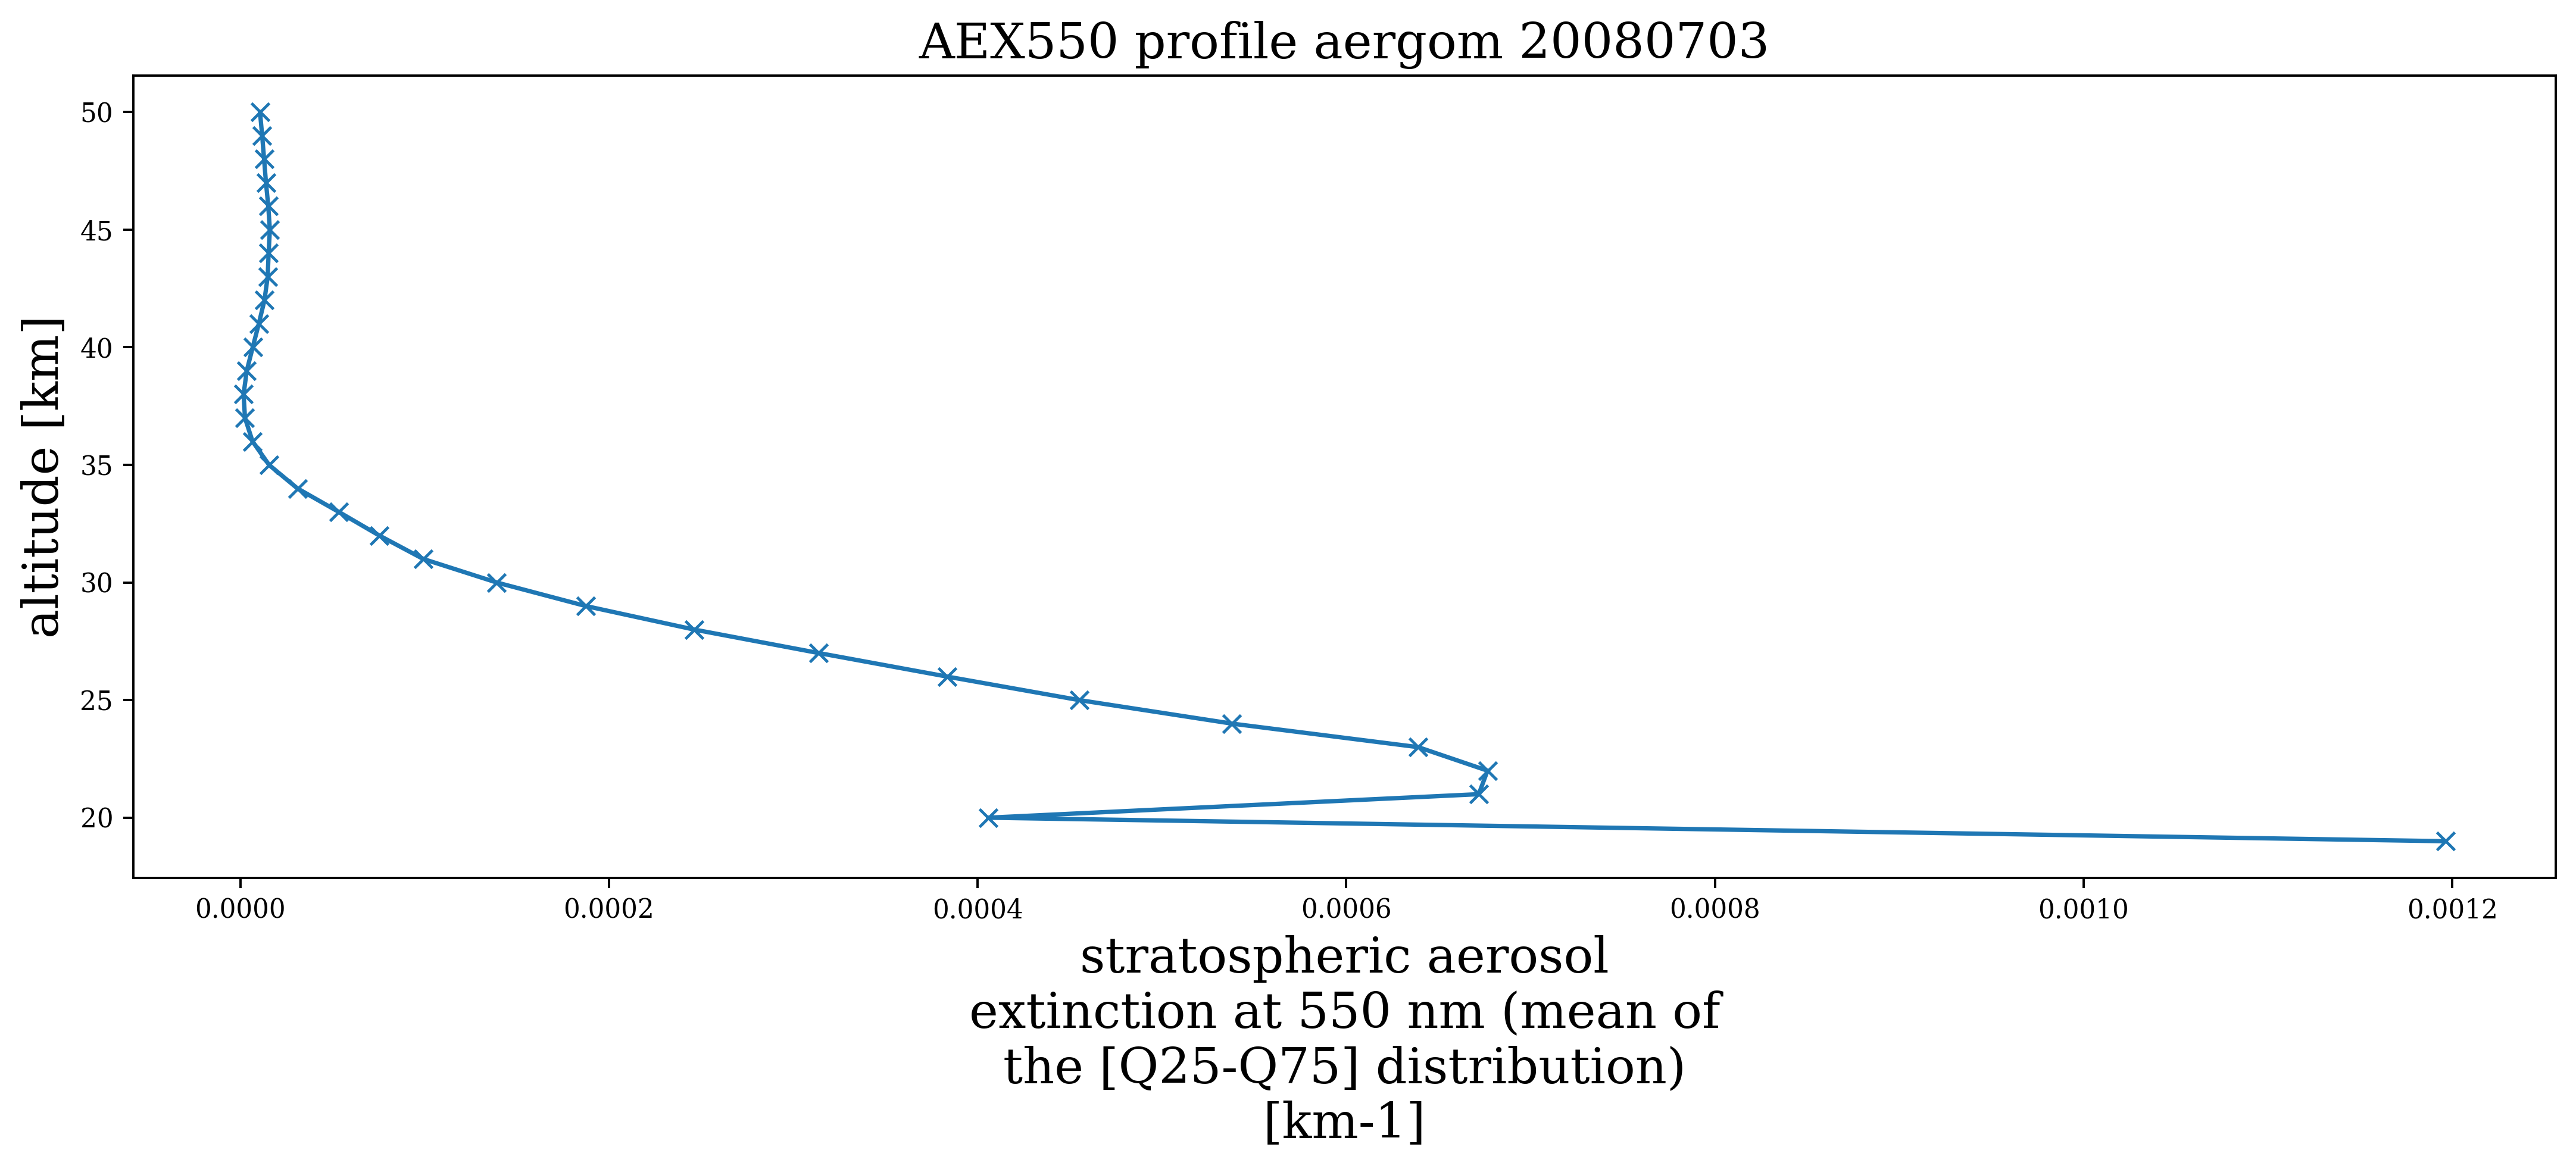

In [48]:
# Select and plot the data
data = getattr(file, variable).sel(lat=-2.5, lon=30) # extracts the data of the choosen variable from the dataset at the choosen location (lat, lon)
data.plot( y='lev', marker='x') # plot the profile
title = variable + ' profile aergom ' + filename[0:8]
plt.title(title)
plt.savefig('./plots/'+title+'.png', dpi=500, bbox_inches='tight')

**FIGURE 8:** This plot of aerosol extinction at the selected location shows a vertical aerosol profile of the GOMOS data with differnet layers at 20 and 23 km altitude.

This closes our first Jupyter notebook on aerosol properties.

A second Jupyter notebook will create a full Climate Data Record by combining subsequent data record pieces of similar sensors.

# Get more information about Aerosol properties and the Climate Data Store

- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
- [About the Climate Data Store](https://cds.climate.copernicus.eu/)
- [About the Toolbox documentation](https://cds.climate.copernicus.eu/toolbox/doc/index.html)

# <a id='references'></a> References

[Product User Guide for CDS Aerosol Properties](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/AER/C3S2_312a_Lot2_PUGS_AER_latest.pdf)

[Thomas Popp, Gerrit de Leeuw, Christine Bingen, Christoph Brühl, Virginie Capelle, Alain Chedin, 
Lieven Clarisse, Oleg Dubovik, Roy Grainger, Jan Griesfeller, Andreas Heckel, Stefan Kinne, Lars Klüser, 
Miriam Kosmale, Pekka Kolmonen, Luca Lelli, Pavel Litvinov, Linlu Mei, Peter North, Simon Pinnock, 
Adam Povey, Charles Robert, Michael Schulz, Larisa Sogacheva, Kerstin Stebel, Deborah Stein Zweers, 
Gareth Thomas, Lieuwe Gijsbert Tilstra, Sophie Vandenbussche, Pepijn Veefkind, Marco Vountas and 
Yong Xue, Development, Production and Evaluation of Aerosol Climate Data Records from European 
Satellite Observations (Aerosol_cci), Remote Sensing, 8, 421; doi:10.3390/rs8050421, 2016](https://www.mdpi.com/2072-4292/8/5/421)




[Back to top the Page](#title)